In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_9\Project.toml`


In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using ControlSystems
using OSQP

In [2]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters
J = 0.2*m*ℓ*ℓ

#Thrust limits
umin = [0.2*m*g; 0.2*m*g]
umax = [0.6*m*g; 0.6*m*g]

h = 0.05 #time step (20 Hz)

0.05

In [3]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/J)*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

quad_dynamics (generic function with 1 method)

In [4]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

quad_dynamics_rk4 (generic function with 1 method)

In [5]:
#Linearized dynamics for hovering
x_hover = zeros(6)
u_hover = [ 0.5*m*g; 0.5*m*g ]
A = ForwardDiff.jacobian(x -> quad_dynamics_rk4(x, u_hover), x_hover)
B = ForwardDiff.jacobian(u -> quad_dynamics_rk4(x_hover, u), u_hover)
quad_dynamics_rk4(x_hover, u_hover)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [6]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [7]:
# Cost weights
Q = Array(1.0*I(Nx))
R = Array(0.01*I(Nu))
Qn = Array(1.0*I(Nx))

6×6 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

In [8]:
#Cost function
function cost(xhist,uhist)
    J = 0.5 * (xhist[:,end])' * Qn * (xhist[:,end])

    for k in 1:(size(xhist, 2)-1)
        J = J + 0.5 * (xhist[:,k])' * Q * (xhist[:,k]) + 0.5 * (uhist[:,k])' * R * (uhist[:,k])[1]
    end

    return J
end

cost (generic function with 1 method)

## LQR Hover Controller

In [9]:
K = dlqr(A, B, Q, R)
P = dare(A, B, Q, R)

function lqr_controller(t,x,K,xref)
    return u_hover - K*(x - xref)
end

lqr_controller (generic function with 1 method)

## MPC Controller

In [10]:
Nh = 20 #one second horizon at 20Hz
Nx = 6
Nu = 2

2

### Case1. $z^T = [ u, x, u, x, u, x, ... , u_{N-1}, x_n ]$

In [11]:
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
Θ = kron(Diagonal(I,Nh), [0 0 0 0 1 0 0 0]) #Matrix that picks out all x3 (θ)
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b1 = zeros(Nh*(Nx+Nu))
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

#Dynamics + Thrust limit constraints
D = [C; U]
lb1 = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover)]
ub1 = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover)]

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
# D = [C; U; Θ]
# lb1 = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover); -0.2*ones(Nh)]
# ub1 = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover); 0.2*ones(Nh)]

prob1 = OSQP.Model()
OSQP.setup!(prob1; P=H, q=b1, A=D, l=lb1, u=ub1, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [12]:
function mpc_controller_case1(t,x,xref)
    
    #Update QP problem
    lb1[1:6] .= -A*x
    ub1[1:6] .= -A*x
    
    for j = 1:(Nh-1)
        b1[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
    end
    b1[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob1, q=b1, l=lb1, u=ub1)

    #Solve QP
    results = OSQP.solve!(prob1)
    Δu = results.x[1:Nu]

    return u_hover + Δu
end

mpc_controller_case1 (generic function with 1 method)

### Case2. $z^T = [ x, x, x, ... ,x_N, u, u, u ... , u_{N-1} ]$

In [13]:
H = blockdiag( sparse(kron(Diagonal(I,Nh), Q)), sparse(Qn), sparse(kron(Diagonal(I,Nh), R)) )
b2 = zeros(Nh*(Nx+Nu)+Nx)

C_left = sparse(kron(Diagonal(I,Nh+1), -I(Nx)) + [zeros(Nx, Nx*(Nh)) zeros(Nx, Nx); kron(Diagonal(I,Nh), A) zeros(Nx*(Nh), Nx)])
C_right = [ zeros(Nx, Nu*Nh); kron(Diagonal(I, Nh), B) ]
C = [C_left C_right]
U = [zeros(Nu*Nh, Nx*(Nh+1)) kron(Diagonal(I, Nh), I(2))]

D = [C; U]
lb2 = [zeros(Nx*(Nh+1)); kron(ones(Nh), umin-u_hover)]
ub2 = [zeros(Nx*(Nh+1)); kron(ones(Nh), umax-u_hover)]

prob2 = OSQP.Model()
OSQP.setup!(prob2; P=H, q=b2, A=D, l=lb2, u=ub2, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [14]:
function mpc_controller_case2(t,x,xref)
    
    #Update QP problem
    lb2[1:Nx] .= -A*x
    ub2[1:Nx] .= -A*x
    
    for j = 1:Nh
        b2[((Nx)*(j-1)).+(1:Nx)] .= -Q*xref
    end
    b2[(Nh*Nx).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob2, q=b2, l=lb2, u=ub2)

    #Solve QP
    results = OSQP.solve!(prob2)
    Δu = results.x[((Nh+1)*Nx).+(1:Nu)]

    return u_hover + Δu
end

mpc_controller_case2 (generic function with 1 method)

## MPC Simulation

In [15]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        xhist[:,k+1] .= quad_dynamics_rk4(xhist[:,k],uhist[:,k])
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [16]:
x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [10.0; 2.0; 0.0; 0; 0; 0]
xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller_case1(t,x,x_ref), Nt);
xhist3, uhist3 = closed_loop(x0, (t,x)->mpc_controller_case2(t,x,x_ref), Nt);
xhist3

6×201 Matrix{Float64}:
 10.0   9.99993      9.99883     9.99394    …   0.105722      0.1032
  2.0   1.99755      1.99191     1.98629        1.9779        1.97791
  0.0  -0.040875    -0.148848   -0.271216       0.0025135     0.00245353
  0.0  -0.00534552  -0.0471391  -0.158975      -0.0510573    -0.0498392
  0.0  -0.0981819   -0.128079   -0.0989884      0.000157298   0.000152003
  0.0  -1.635       -2.68393    -2.21079    …  -0.00121385   -0.00118487

## Plotting

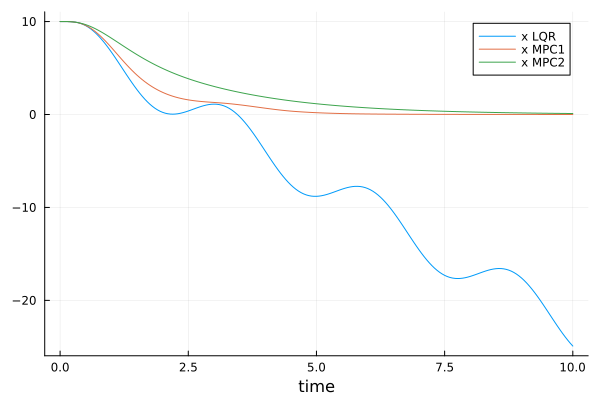

In [17]:
plot(thist,xhist1[1,:], label="x LQR")
plot!(thist,xhist2[1,:], label="x MPC1")
plot!(thist,xhist3[1,:], label="x MPC2")
xlabel!("time")

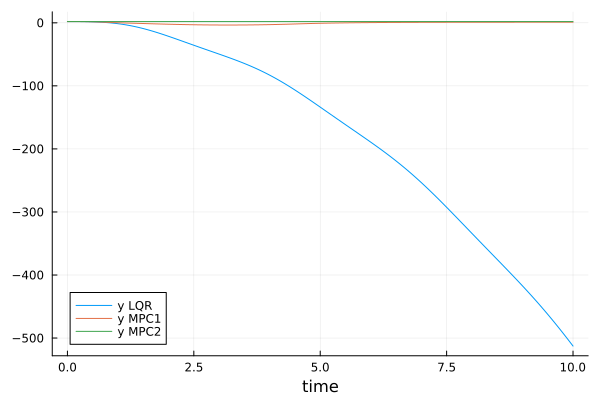

In [18]:
plot(thist,xhist1[2,:], label="y LQR")
plot!(thist,xhist2[2,:], label="y MPC1")
plot!(thist,xhist3[2,:], label="y MPC2")
xlabel!("time")

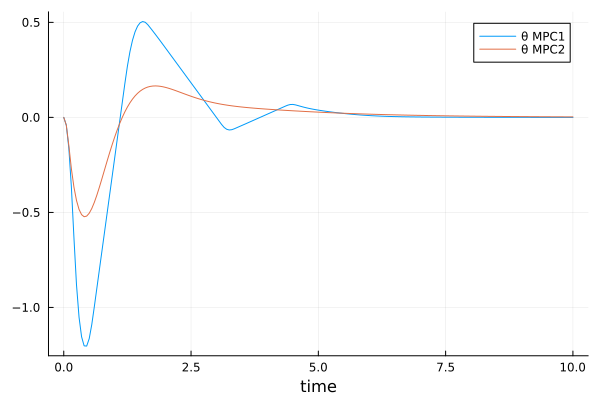

In [19]:
plot(thist,xhist2[3,:], label="θ MPC1")
plot!(thist,xhist3[3,:], label="θ MPC2")
# plot!(thist,xhist1[3,:], label="θ LQR")
xlabel!("time")

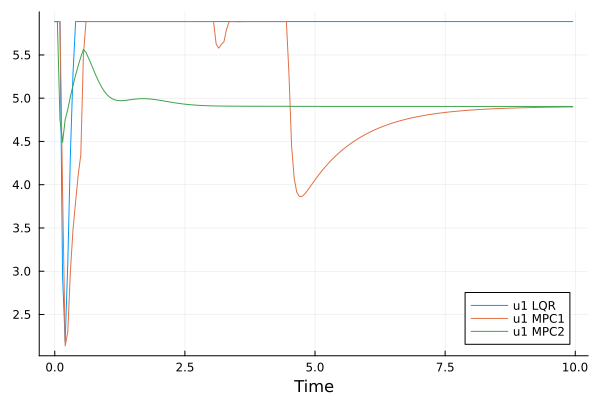

In [20]:
plot(thist[1:end-1], uhist1[1,:], label="u1 LQR")
plot!(thist[1:end-1], uhist2[1,:], label="u1 MPC1")
plot!(thist[1:end-1], uhist3[1,:], label="u1 MPC2")
xlabel!("Time")

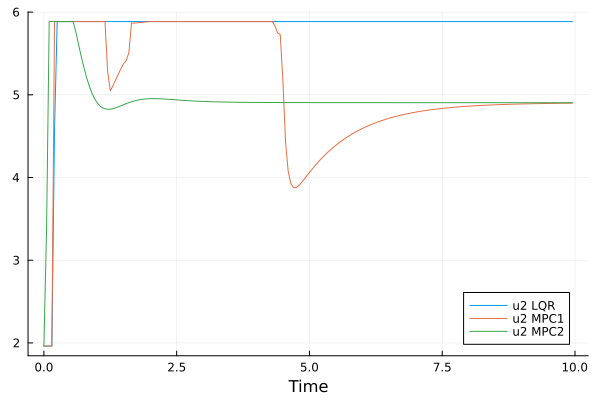

In [21]:
plot(thist[1:end-1], uhist1[2,:], label="u2 LQR")
plot!(thist[1:end-1], uhist2[2,:], label="u2 MPC1")
plot!(thist[1:end-1], uhist3[2,:], label="u2 MPC2")
xlabel!("Time")

In [22]:
#Set up visualization
using MeshCat
using RobotZoo: Quadrotor, PlanarQuadrotor
using CoordinateTransformations, Rotations, Colors, StaticArrays, RobotDynamics

function set_mesh!(vis, model::L;
        scaling=1.0, color=colorant"black"
    ) where {L <: Union{Quadrotor, PlanarQuadrotor}} 
    # urdf_folder = joinpath(@__DIR__, "..", "data", "meshes")
    urdf_folder = @__DIR__
    # if scaling != 1.0
    #     quad_scaling = 0.085 * scaling
    obj = joinpath(urdf_folder, "quadrotor_scaled.obj")
    if scaling != 1.0
        error("Scaling not implemented after switching to MeshCat 0.12")
    end
    robot_obj = MeshFileGeometry(obj)
    mat = MeshPhongMaterial(color=color)
    setobject!(vis["robot"]["geom"], robot_obj, mat)
    if hasfield(L, :ned)
        model.ned && settransform!(vis["robot"]["geom"], LinearMap(RotX(pi)))
    end
end

function visualize!(vis, model::PlanarQuadrotor, x::StaticVector)
    py,pz = x[1], x[2]
    θ = x[3]
    settransform!(vis["robot"], compose(Translation(0,py,pz), LinearMap(RotX(-θ))))
end

function visualize!(vis, model, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{6}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [23]:
vis = Visualizer()
model = PlanarQuadrotor()
set_mesh!(vis, model)
render(vis)

[ Info: Listening on: 127.0.0.1:8701, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001c78) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000085fa7d00)))

In [24]:
X1 = [SVector{6}(x) for x in eachcol(xhist1)];
X2 = [SVector{6}(x) for x in eachcol(xhist2)];
X3 = [SVector{6}(x) for x in eachcol(xhist3)];

## LQR Simulation

In [25]:
visualize!(vis, model, thist[end], X1)

## MPC Simulation

In [26]:
visualize!(vis, model, thist[end], X2)

In [27]:
visualize!(vis, model, thist[end], X3)

# MPC with θ constraint

### Improve Case1. $z^T = [ u, x, u, x, u, x, ... , u_{N-1}, x_n ]$

In [28]:
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
Θ = kron(Diagonal(I,Nh), [0 0 0 0 1 0 0 0]) #Matrix that picks out all x3 (θ)
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b1 = zeros(Nh*(Nx+Nu))
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

#Dynamics + Thrust limit constraints
# D = [C; U]
# lb1 = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover)]
# ub1 = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover)]

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
D = [C; U; Θ]
lb1 = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover); -0.2*ones(Nh)]
ub1 = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover); 0.2*ones(Nh)]

prob1 = OSQP.Model()
OSQP.setup!(prob1; P=H, q=b1, A=D, l=lb1, u=ub1, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [29]:
function mpc_controller_case1(t,x,xref)
    
    #Update QP problem
    lb1[1:6] .= -A*x
    ub1[1:6] .= -A*x
    
    for j = 1:(Nh-1)
        b1[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
    end
    b1[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob1, q=b1, l=lb1, u=ub1)

    #Solve QP
    results = OSQP.solve!(prob1)
    Δu = results.x[1:Nu]
    # @show Δu

    return u_hover + Δu
end

mpc_controller_case1 (generic function with 1 method)

## Simulation Again

In [30]:
x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [10.0; 2.0; 0.0; 0; 0; 0]
xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller_case1(t,x,x_ref), Nt);

## Plotting

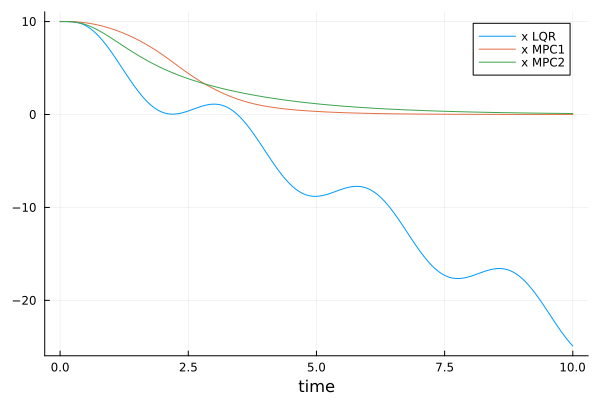

In [31]:
plot(thist,xhist1[1,:], label="x LQR")
plot!(thist,xhist2[1,:], label="x MPC1")
plot!(thist,xhist3[1,:], label="x MPC2")
xlabel!("time")

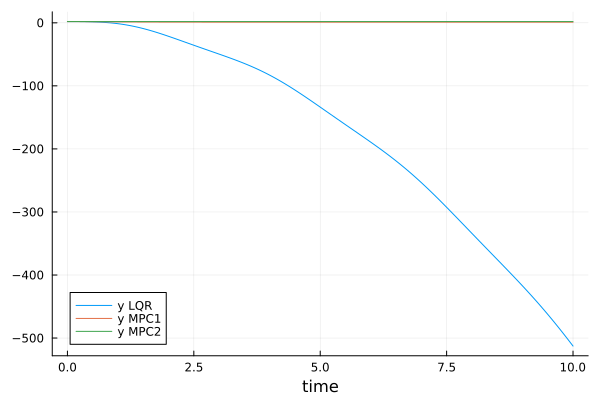

In [32]:
plot(thist,xhist1[2,:], label="y LQR")
plot!(thist,xhist2[2,:], label="y MPC1")
plot!(thist,xhist3[2,:], label="y MPC2")
xlabel!("time")

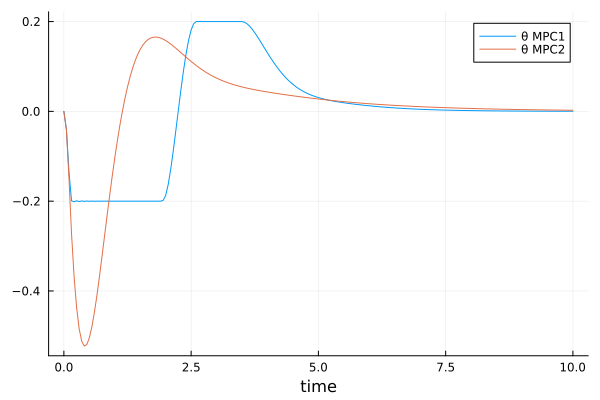

In [33]:
plot(thist,xhist2[3,:], label="θ MPC1")
plot!(thist,xhist3[3,:], label="θ MPC2")
# plot!(thist,xhist1[3,:], label="θ LQR")
xlabel!("time")

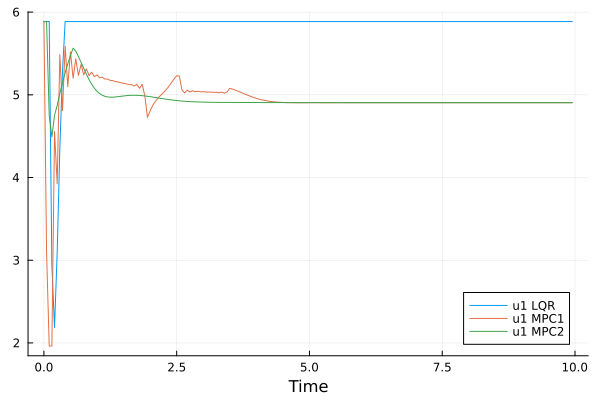

In [35]:
plot(thist[1:end-1], uhist1[1,:], label="u1 LQR")
plot!(thist[1:end-1], uhist2[1,:], label="u1 MPC1")
plot!(thist[1:end-1], uhist3[1,:], label="u1 MPC2")
xlabel!("Time")

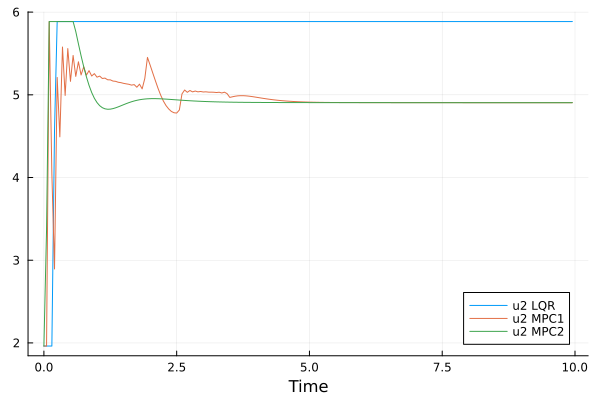

In [36]:
plot(thist[1:end-1], uhist1[2,:], label="u2 LQR")
plot!(thist[1:end-1], uhist2[2,:], label="u2 MPC1")
plot!(thist[1:end-1], uhist3[2,:], label="u2 MPC2")
xlabel!("Time")

In [37]:
X1 = [SVector{6}(x) for x in eachcol(xhist1)];
X2 = [SVector{6}(x) for x in eachcol(xhist2)];
X3 = [SVector{6}(x) for x in eachcol(xhist3)];

In [38]:
vis = Visualizer()
model = PlanarQuadrotor()
set_mesh!(vis, model)
render(vis)

[ Info: Listening on: 127.0.0.1:8702, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8702, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8702), "127.0.0.1", "8702", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001cc4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000008f876d60)))

## Simulate improved MPC

In [39]:
visualize!(vis, model, thist[end], X2)

In [108]:
visualize!(vis, model, thist[end], X3)